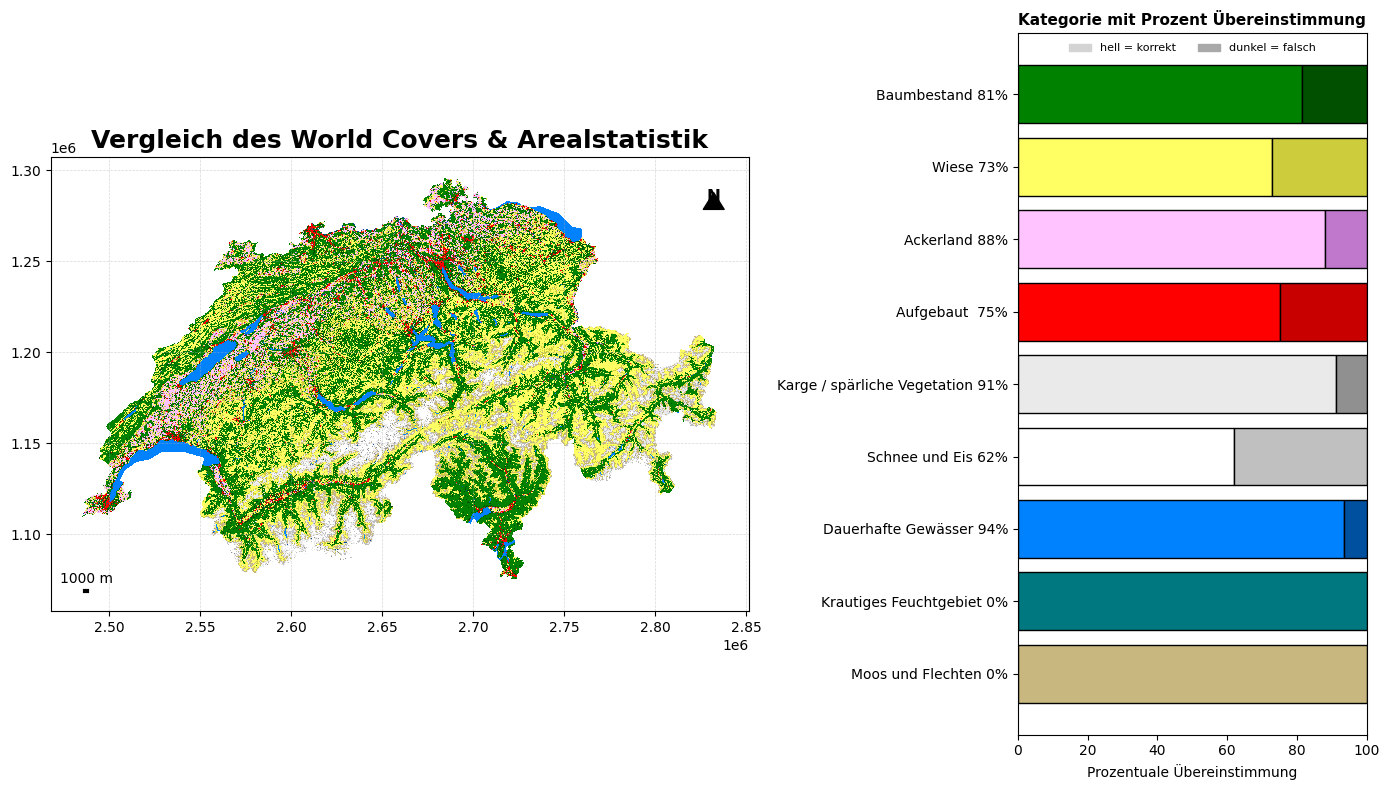

In [22]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib.patches as mpatches

# -----------------------------
# 1. GeoPackage laden
# -----------------------------
gpkg_path = "../../data/analysis/worldcover/arealstatistik_mapped_2020_v2.gpkg"
gdf = gpd.read_file(gpkg_path)

# CRS prüfen und ggf. auf EPSG:2056 setzen
if gdf.crs.to_epsg() != 2056:
    gdf = gdf.to_crs(epsg=2056)

# -----------------------------
# 2. Kategorie-Farben definieren
# -----------------------------
category_colors = {
    10: "#006400",   # Forest land -> grün
    30: "#ffff4c",   # Cropland -> braun
    40: "#f096ff",   # Grassland -> gelb
    50: "#fa0000",   # Wetlands -> blau
    60: "#b4b4b4",   # Settlements -> grau
    70: "#f0f0f0",    # Other Land -> pink
    80: "#0064c8",   # Water bodies -> dunkelrot
    90: "#0096a0",    # No data -> weiß
    100: "#fae6a0",    # Sparse vegetation -> hellgrau
}

def adjust_brightness(color, factor):
    rgb = np.array(to_rgb(color))
    rgb = np.clip(rgb * factor, 0, 1)
    return rgb

color_low_sat = {k: adjust_brightness(v, 1.3) for k, v in category_colors.items()}  # hell = korrekt
color_high_sat = {k: adjust_brightness(v, 0.8) for k, v in category_colors.items()} # kräftig = falsch

# -----------------------------
# 3. Farbe pro Polygon zuweisen
# -----------------------------
def get_color(row):
    a_cat = row["WorldCover_2020_class_1"]
    b_cat = row["AS_auf_WorldCover"]
    if a_cat == b_cat:
        return color_low_sat.get(a_cat, "#ffffff")
    else:
        return color_high_sat.get(a_cat, "#ffffff")

gdf["plot_color"] = gdf.apply(get_color, axis=1)

# -----------------------------
# 4. Übereinstimmungsraten pro Kategorie
# -----------------------------
accuracy_per_class = []
for cat in category_colors.keys():
    mask_class = gdf["WorldCover_2020_class_1"] == cat
    correct = np.sum(gdf.loc[mask_class, "AS_auf_WorldCover"] == cat)
    total = np.sum(mask_class)
    pct = (correct / total * 100) if total > 0 else 0
    accuracy_per_class.append((cat, pct))

# -----------------------------
# 5. Karte + Balken-Legende plotten
# -----------------------------
fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=(14, 8), width_ratios=[2, 1])

# Karte
gdf.plot(ax=ax_map, color=gdf["plot_color"], edgecolor="none", linewidth=0.2)
ax_map.set_title("Vergleich des World Covers & Arealstatistik", fontsize=18, fontweight="bold")
ax_map.axis("on")

# -----------------------------
# 5a. Koordinatenband
# -----------------------------

ax_map.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# -----------------------------
# 5b. Nordpfeil
# -----------------------------
# Position in Datenkoordinaten (oben rechts)
xlim = ax_map.get_xlim()
ylim = ax_map.get_ylim()
arrow_x = xlim[1] - (xlim[1]-xlim[0])*0.05
arrow_y = ylim[1] - (ylim[1]-ylim[0])*0.1
ax_map.annotate('N', xy=(arrow_x, arrow_y + (ylim[1]-ylim[0])*0.02),
                xytext=(arrow_x, arrow_y),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', fontsize=12, fontweight='bold')

# -----------------------------
# 5c. Maßstab
# -----------------------------
# Einfacher Maßstab: Linie + Text
scalebar_length = 1000  # 1000 Meter
scalebar_x = xlim[0] + (xlim[1]-xlim[0])*0.05
scalebar_y = ylim[0] + (ylim[1]-ylim[0])*0.02
ax_map.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y], color='black', linewidth=3)
ax_map.text(scalebar_x + scalebar_length/2, scalebar_y + (ylim[1]-ylim[0])*0.01, f"{scalebar_length} m",
            ha='center', va='bottom', fontsize=10)

# -----------------------------
# Balken-Legende
# -----------------------------
for idx, (cat, pct) in enumerate(accuracy_per_class):
    incorrect_pct = 100 - pct
    ax_bar.barh(idx, pct, color=color_low_sat[cat], edgecolor='black')
    ax_bar.barh(idx, incorrect_pct, left=pct, color=color_high_sat[cat], edgecolor='black')

# Y-Achse: Kategorie + Prozentwert IPCC Kategorien
category_names = {
    10: "Baumbestand",
    30: "Wiese",
    40: "Ackerland",
    50: "Aufgebaut ",
    60: "Karge / spärliche Vegetation",
    70: "Schnee und Eis",
    80: "Dauerhafte Gewässer",
    90: "Krautiges Feuchtgebiet",
    100: "Moos und Flechten"
}
ax_bar.set_yticks(range(len(category_colors)))
ax_bar.set_yticklabels([f"{category_names[cat]} {pct:.0f}%" for (cat, pct) in accuracy_per_class])

# X-Achse
ax_bar.set_xlim(0, 100)
ax_bar.set_xlabel("Prozentuale Übereinstimmung")

# Titel oberhalb der Balken
ax_bar.set_title("Kategorie mit Prozent Übereinstimmung", fontsize=11, fontweight="bold")

# Erklärung hell/dunkel horizontal
legend_patches = [
    mpatches.Patch(color="lightgrey", label="hell = korrekt"),
    mpatches.Patch(color="darkgrey", label="dunkel = falsch")
]
ax_bar.legend(handles=legend_patches, loc="upper center", fontsize=8, ncol=2, frameon=False)

plt.gca().invert_yaxis()  # Balken von oben nach unten
plt.tight_layout()
plt.show()


versuch 2

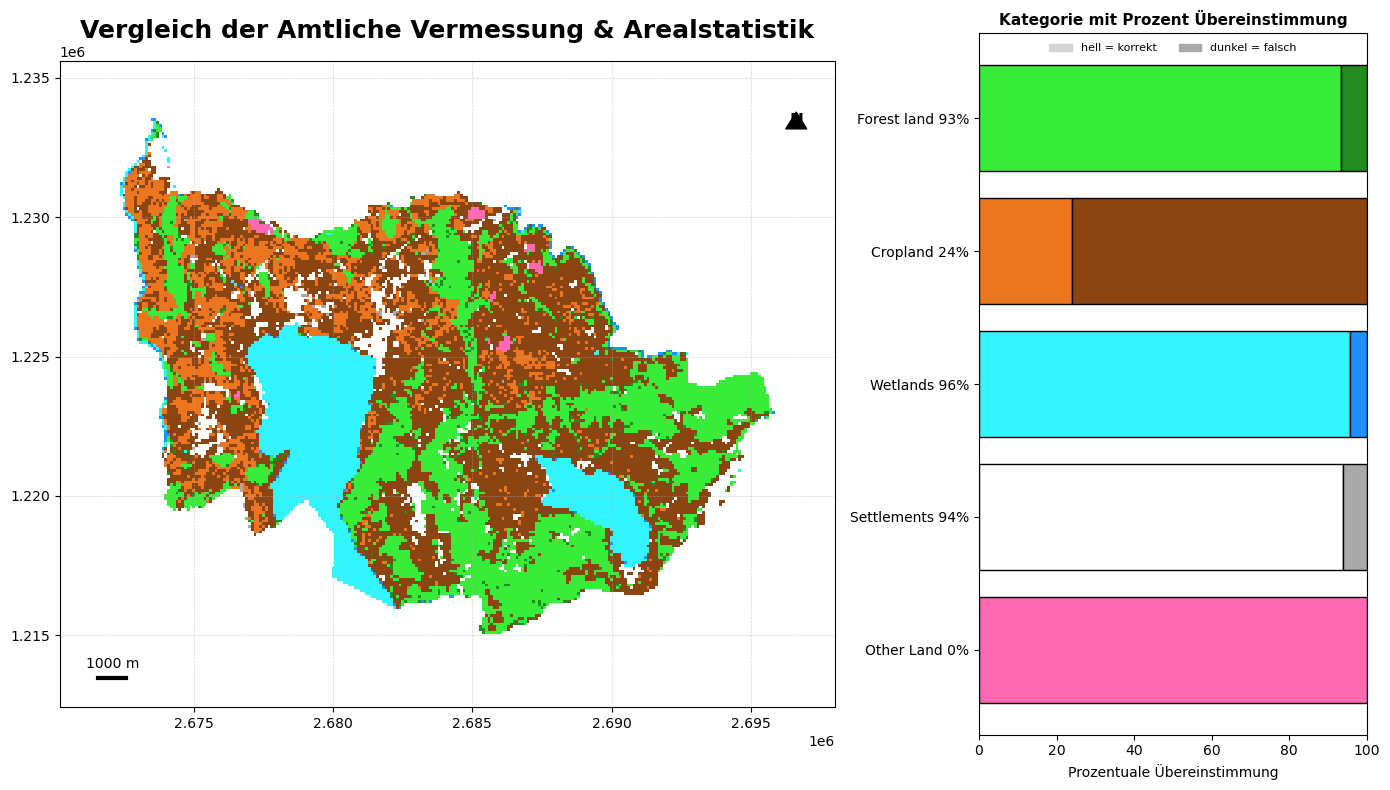